plot kd from argo, ws profiles, and ooi array

In [1]:
%pip install --quiet geopy

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, timezone
import matplotlib.pyplot as plt
from scipy import stats
import glob
from geopy.distance import geodesic

In [2]:
def matchkd_turb(file_name):
    is2 = pd.read_csv(file_name)# load data
    t = datetime.strptime(file_name[8:22],'%Y%m%d%H%M%S')# strip time from file name
    t = t.replace(tzinfo=timezone.utc)
    tdiff = abs(t - turb['time']) # calculate difference between file time and each argo entry
    
    # find all entries in argo where tdiff<6h
    turb_sub = turb[tdiff<(timedelta(hours=14))]
    rows = turb_sub.index.values

    # find all possible matched entries where distance is < 10km
    for jj in rows:
        dist = np.ones(len(is2))*np.nan
        turb_coords = (turb_sub.loc[jj,'lat'],turb_sub.loc[jj,'lon']) #lat,lon tuple
        for kk in range(len(is2)):
            is2_coords = (is2.loc[kk,'latitude'],is2.loc[kk,'longitude'])
            try:
                dist[kk] = geodesic(turb_coords, is2_coords).km
            except:
                continue
        idx = np.argmin(dist)
        if np.min(dist)<10:
            turb.loc[jj,'icesat2_kd'] = is2.loc[idx,'kd']
            turb.loc[jj,'dist_offset'] = np.min(dist)
            turb.loc[jj,'time_offset'] = tdiff[jj]



In [3]:
pname = 'results/'
# load turbidity data:
turb = pd.read_csv(pname+'all_turbidity_compile.csv',index_col=0)
turb['time'] = pd.to_datetime(turb["time"],format='ISO8601').round('s')
turb['icesat2_kd'] = np.nan
turb['dist_offset'] = np.nan
turb['time_offset'] = timedelta(hours=0)
fnames = glob.glob(pname+'*Further.csv')
for file in fnames:
    matchkd_turb(file)


(0.01, 0.45)

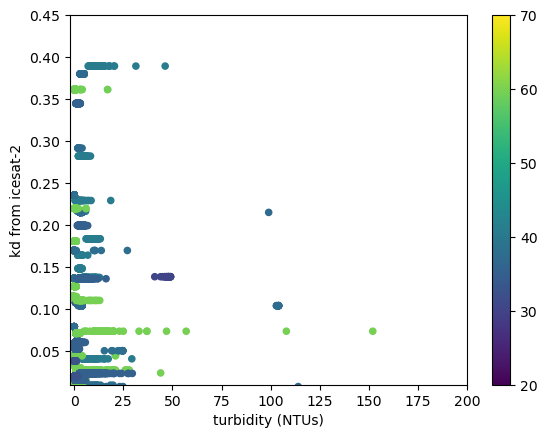

In [12]:
# color by latitude
plt.figure()
p = plt.scatter(turb['turb'],turb['icesat2_kd'],s=20,c=turb['lat'],vmin=20,vmax=70)
# plt.axline((0, 0), slope=1,c='k')
plt.colorbar(p)
plt.xlabel('turbidity (NTUs)')
plt.ylabel('kd from icesat-2')
# plt.yscale('log')
# plt.xscale('log')
plt.xlim([-2,200])
plt.ylim([0.01,0.45])

(0.01, 0.45)

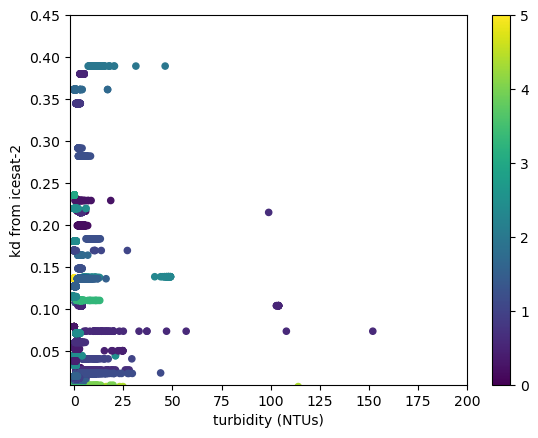

In [6]:
# color by distance offset (km) between buoy and icesat-2
plt.figure()
p = plt.scatter(turb['turb'],turb['icesat2_kd'],s=20,c=turb['dist_offset'],vmin=0,vmax=5)
plt.colorbar(p)
plt.xlabel('turbidity (NTUs)')
plt.ylabel('kd from icesat-2')
plt.xlim([-2,200])
plt.ylim([0.01,0.45])

(0.01, 0.45)

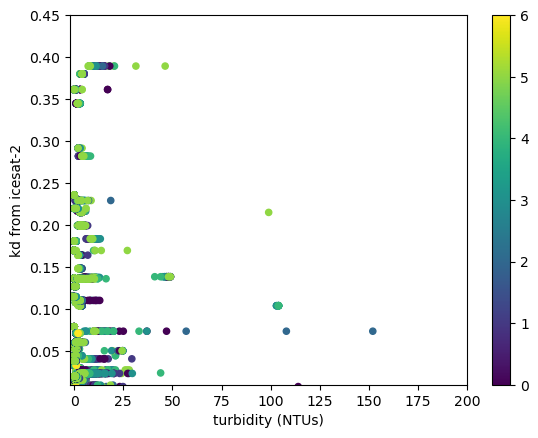

In [10]:
# color by time offset (hours) between buoy and icesat-2
plt.figure()
p = plt.scatter(turb['turb'],turb['icesat2_kd'],s=20,c=turb['time_offset']/3.6e9,vmin=0,vmax=6)
plt.colorbar(p)
plt.xlabel('turbidity (NTUs)')
plt.ylabel('kd from icesat-2')
plt.xlim([-2,200])
plt.ylim([0.01,0.45])